In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
!pip install -q ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# # metadata
# print(statlog_german_credit_data.metadata)

# # variable information
# print(statlog_german_credit_data.variables)

In [4]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [5]:
le = [
    'Attribute1',
    'Attribute3',
    'Attribute4',
    'Attribute6',
    'Attribute7',
    'Attribute9',
    'Attribute10',
    'Attribute12',
    'Attribute14',
    'Attribute15',
    'Attribute17',
    'Attribute19',
    'Attribute20',
]

In [6]:
label_enc = LabelEncoder()
label_enc.fit(X[le].to_numpy().flatten())

for col in le:
    X.loc[:, (col)] = label_enc.transform(X[col])


In [7]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,3,6,29,34,1169,44,49,4,52,0,4,5,67,13,15,2,19,1,22,23
1,4,48,27,34,5951,40,47,2,51,0,2,5,22,13,15,1,19,1,21,23
2,10,12,29,37,2096,40,48,2,52,0,3,5,49,13,15,1,18,2,21,23
3,3,42,27,33,7882,40,48,2,52,2,4,6,45,13,16,1,19,2,21,23
4,3,24,28,30,4870,40,47,3,52,0,4,8,53,13,16,2,19,2,21,23


In [8]:
norm = StandardScaler()
norm.fit(X)
df = norm.transform(X)

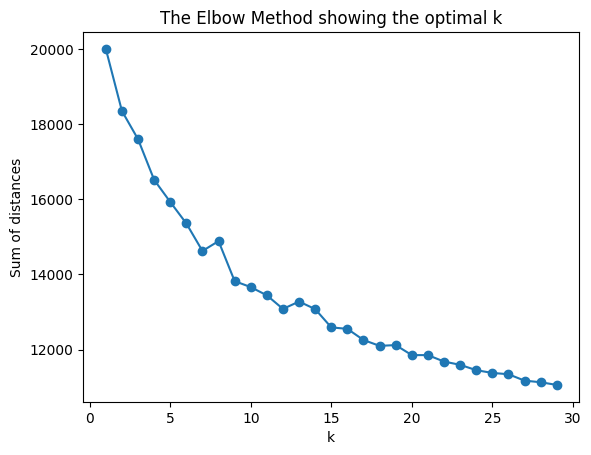

In [ ]:
K = range(1, 30)
models = [KMeans(n_clusters=k).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
model = KMeans(n_clusters=2)
model.fit(X[le])
X['cluster'] = model.labels_
X.groupby('cluster').mean()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
cluster,,,,,,,,,,,,,,,,,,,,
0,3.495396,22.003683,27.353591,33.230203,3498.386740,40.834254,47.252302,2.968692,51.666667,0.206262,2.874770,6.395948,34.716390,12.640884,14.917127,1.368324,18.887661,1.152855,21.383057,23.036832
1,9.862144,19.595186,27.772429,33.332604,3001.387309,41.426696,47.540481,2.978118,51.700219,0.07221,2.809628,6.31291,36.531729,12.715536,14.943107,1.452954,18.923414,1.157549,21.428884,23.037199


In [ ]:
X['cluster'] = X['cluster']+1
X['cluster'].value_counts()

,count
cluster,
1,543
2,457


In [ ]:
y['class'].value_counts()

,count
class,
1,700
2,300


In [ ]:
accuracy_score(y, X['cluster'])

0.363

In [29]:
norm = StandardScaler()

DATA = {
    'all data': norm.fit_transform(X),
    'without label encoder data': norm.fit_transform(X.loc[:, ~X.columns.isin(le)]),
    'without non-label encoder data': norm.fit_transform(X[le])
}

In [13]:
from collections import defaultdict

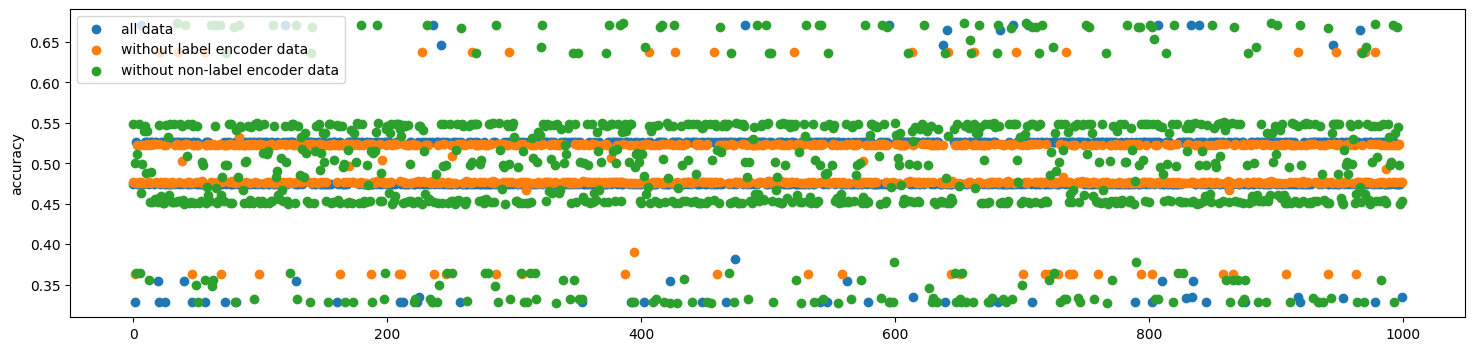

In [35]:
acc_results = defaultdict(list)

model = KMeans(n_clusters=2)

plt.figure(figsize=(18, 4))
for key, data in DATA.items():
    for _ in range(1_000):
        model.fit(data)
        acc_results[key].append(accuracy_score(y, model.labels_+1))

    plt.scatter(np.arange(1_000), acc_results[key], label=key)

plt.ylabel('accuracy')
plt.legend()

In [36]:
for key, value in acc_results.items():
    print(key)
    print(f'max: {np.max(value)}, min: {np.min(value)}, median: {round(np.mean(value), 4)}')
    print('='*50)

all data
max: 0.671, min: 0.329, median: 0.4942
without label encoder data
max: 0.637, min: 0.363, median: 0.4967
without non-label encoder data
max: 0.673, min: 0.327, median: 0.4911
